# Paramagnetic Relaxation Enhancement: Scalar Relaxation

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Part 1: Relaxation via exchange

We start by building the spin-system  with a $^{13}$C and an electron. In the first set of examples, relaxation will be induced by a scalar coupling that varies in magnitude, so we need to copies of the System/Experiment object with different values of the hyperfine coupling

In [3]:
ex0=RS.ExpSys(v0H=600,Nucs=['13C','e-'],LF=True)     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex1=ex0.copy()
ex0.set_inter(Type='hyperfine',i0=0,i1=1,Axx=2.5e5,Ayy=2.5e5,Azz=2.5e5)    #Hyperfine coupling
ex1.set_inter(Type='hyperfine',i0=0,i1=1,Axx=-2.5e5,Ayy=-2.5e5,Azz=-2.5e5)    #Hyperfine coupling

Below, we create the Liouvillian, add an exchange matrix to it, and generator a propagator for 100 ms

In [4]:
L=RS.Liouvillian((ex0,ex1))
tc=1e-12     #Correlation time
p1=0.5  #Population of state 1

L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1)
U=L.U(Dt=.1) #Propagator for 100 ms
_=U.eig()

Below, we investigate the impact of the exchange of the isotropic (scalar) hyperfine coupling on the $^{13}$C magnetization

<IPython.core.display.Javascript object>


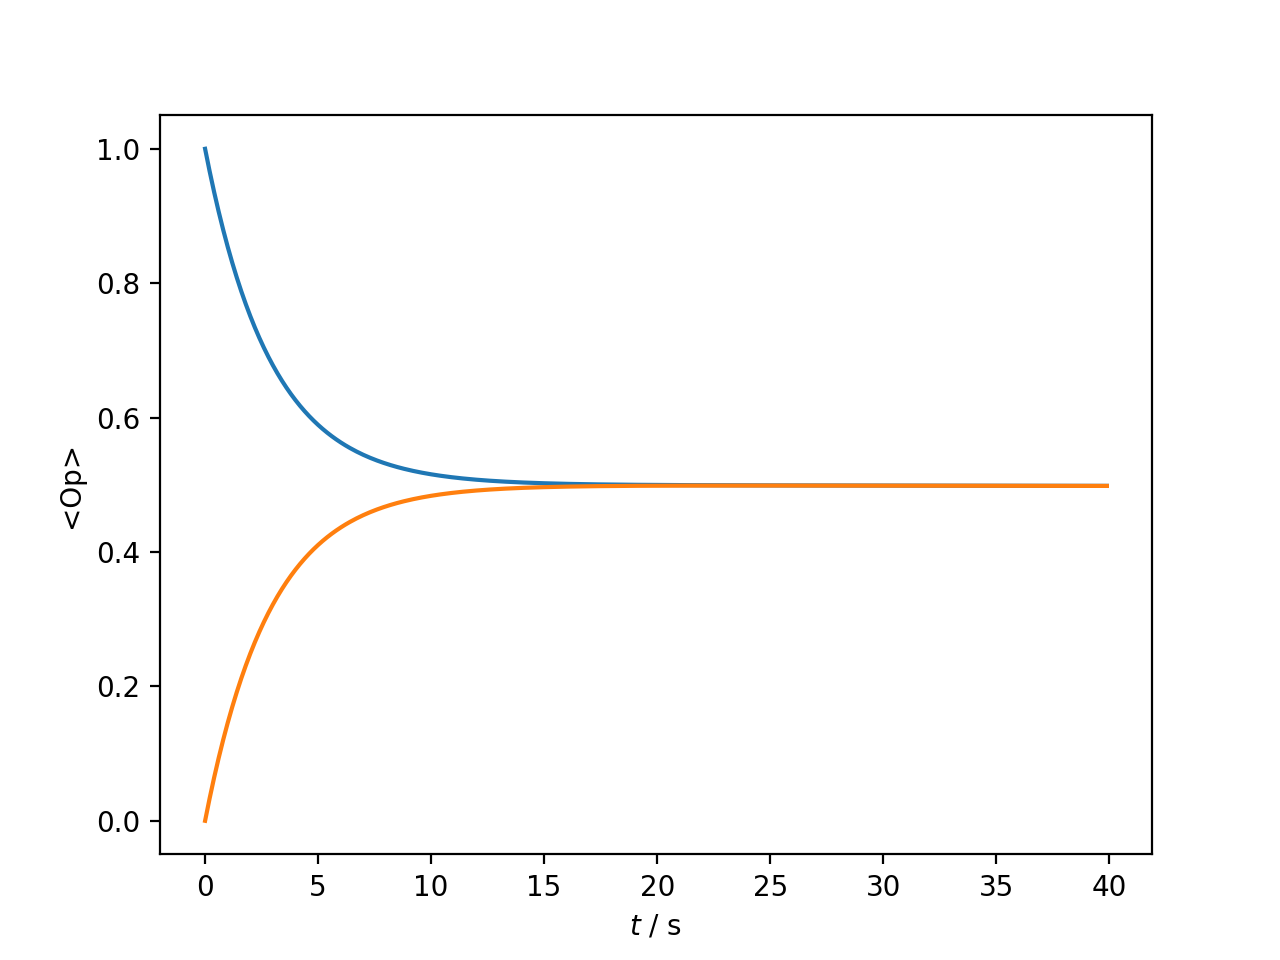

<AxesSubplot:xlabel='$t$ / s', ylabel='<Op>'>

In [5]:
rho=RS.Rho(rho0='13Cz',detect=['13Cz','ez'])
rho.DetProp(U,n=400)
rho.plot(axis='s')

We note that the action of the $T_{00}^{IS}$ operator on $I_z$ magnetization is to produce a difference term, $(I_z-S_z)$. We know this from the following commutators:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I_z\right]\right]&=&0 \\
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I_z\right]\right]&=&\frac1{12}(I_z-S_z)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I_z\right]\right]&=&\frac1{12}(I_z-S_z)
\end{eqnarray}
Then, the expected result is an Overhauser effect, i.e. a transfer of magnetization from the polarized spin to the unpolarized spin. Indeed, this is what we observe for the longitudinal $^{13}$C magnetization, which then transfers to the electron.

<IPython.core.display.Javascript object>


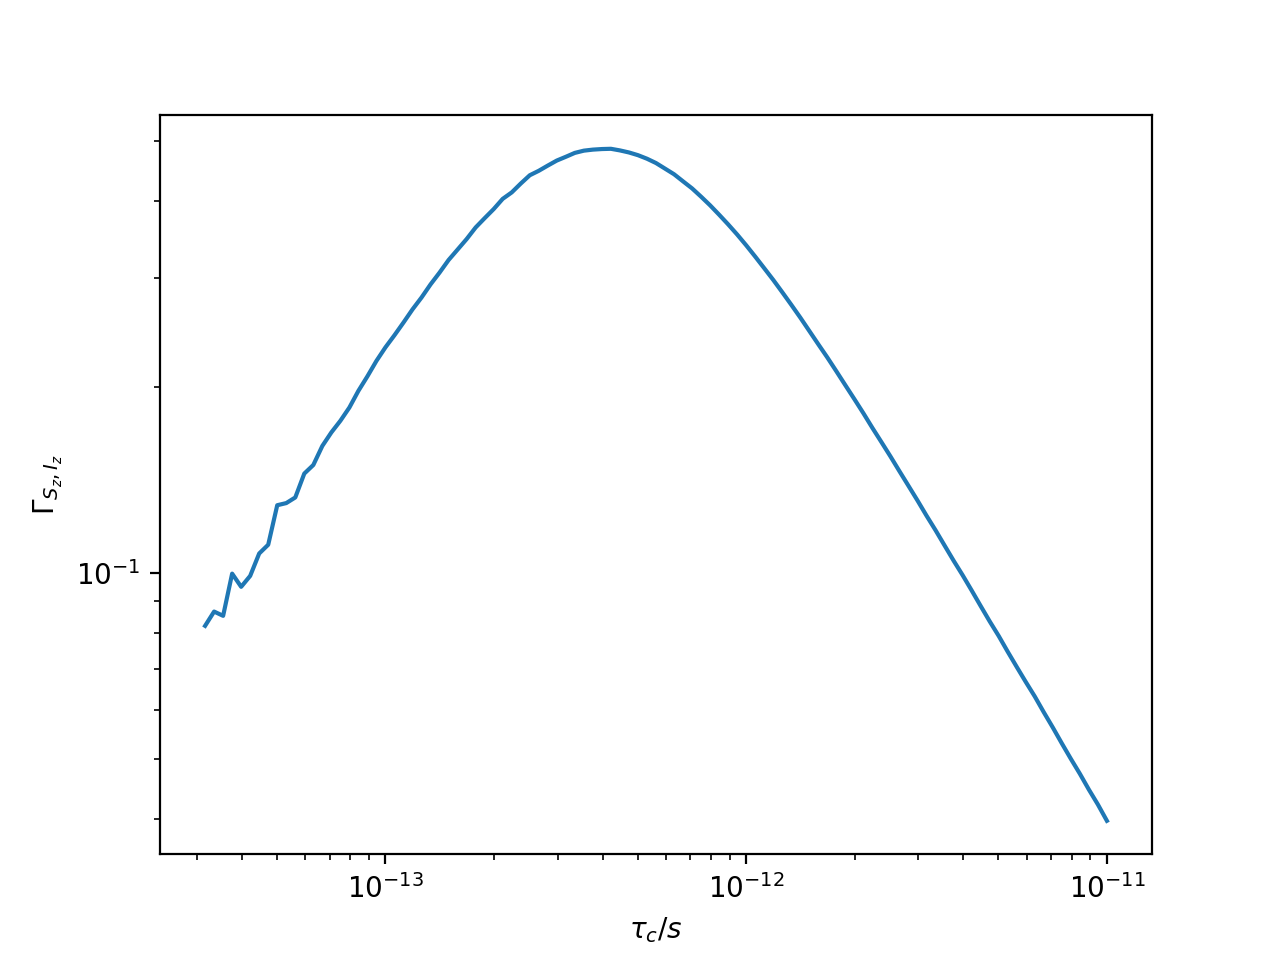

Text(0, 0.5, '$\\Gamma_{S_z,I_z}$')

In [7]:
tc0=np.logspace(-13.5,-11,101)
rate=list()
rho=RS.Rho(rho0='13Cz',detect='13Cz')
for tc in tc0:
    rho.clear()
    L.kex=RS.Tools.twoSite_kex(tc=tc)
    U=L.U(Dt=.1)
    (U*rho)()
    rate.append(2*(1-rho.I[0][0].real)/rho.t)
ax=plt.subplots(1,1)[1]
ax.loglog(tc0,np.array(rate))
ax.set_xlabel(r'$\tau_c / s$')
ax.set_ylabel(r'$\Gamma_{S_z,I_z}$')

We see that the maximum relaxation rate occurs approximately at the inverse of the electron Larmor frequence, $1/\omega_{0e}$, or ~400 fs. 

In the next step, we investigate the impact of modulation of the scalar coupling on transverse $^{13}$C magnetization

<IPython.core.display.Javascript object>


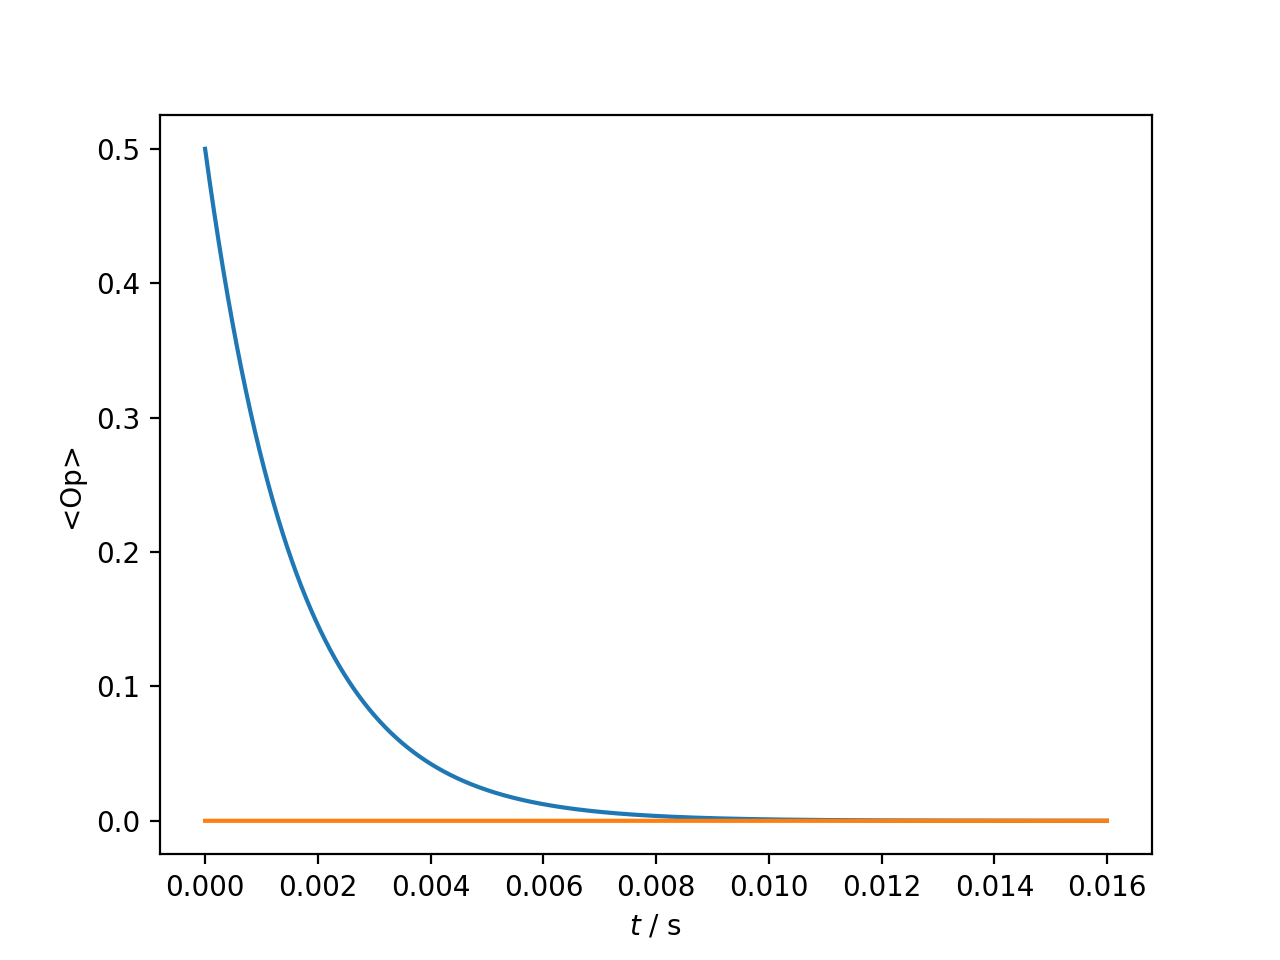

<AxesSubplot:xlabel='$t$ / s', ylabel='<Op>'>

In [8]:
L.kex=RS.Tools.twoSite_kex(tc=1e-9)
U=L.U(Dt=2/5e5)  #Sample such that we back fold the hyperfine to one line
rho=RS.Rho(rho0='13Cx',detect=['13Cp','ep'])
rho.DetProp(U,n=4000)
rho.plot(axis='s',mode='abs')

The action of the $T_{00}^{IS}$ operator on $I^+$ magnetization is to produce a difference term, $(I^+-S^+)$, as seen from the following commutators
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I^+\right]\right]&=&\frac1{12}(I^+-S^+) \\
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I^+\right]\right]&=&\frac1{12}(I^+-S^+)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I^+\right]\right]&=&0
\end{eqnarray}
The double commutators acting on $I^+$ yields $I^+-S^+$, although we do not observe buildup on the electron. The difference in Larmor frequencies prevents any net gain on the electrons despite the appearance of this term in the commutator.

Next, we investigate the relaxation behavior as a function of $\tau_c$

<IPython.core.display.Javascript object>


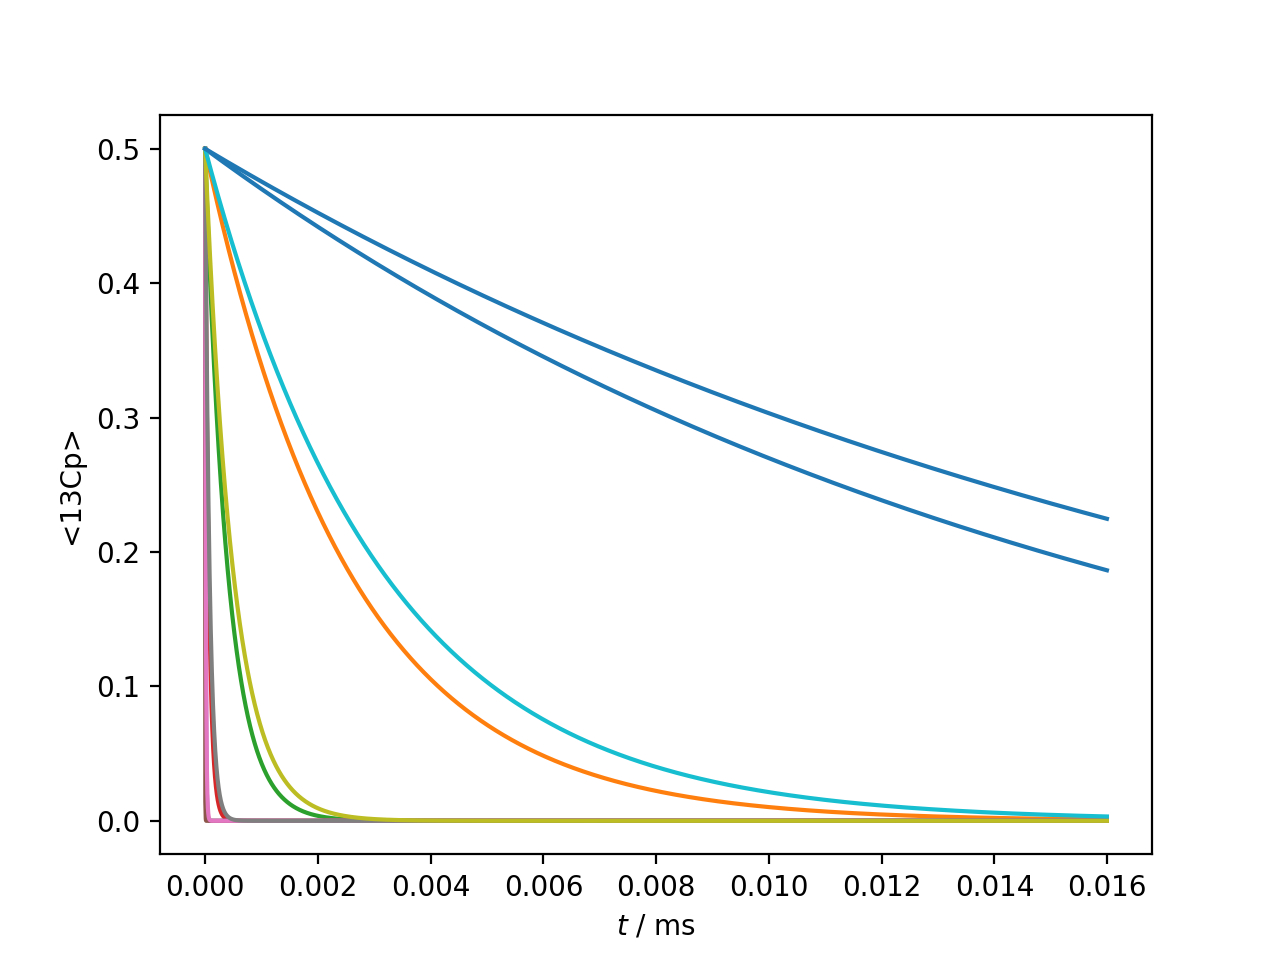

In [9]:
tc0=np.logspace(-10,-2,201)
rate=list()
rho=RS.Rho(rho0='13Cx',detect='13Cp')
ax=plt.subplots(1,1)[1]
for k,tc in enumerate(tc0):
    rho.clear()
    L.kex=RS.Tools.twoSite_kex(tc=tc)
    U=L.U(Dt=2/5e5)
#     (U*rho)()
    rho.DetProp(U,n=4000)
    if k%20==0:
        rho.plot(ax=ax,mode='abs')
    rate.append((0.5-np.abs(rho.I[0][1]))/U.Dt)

<IPython.core.display.Javascript object>


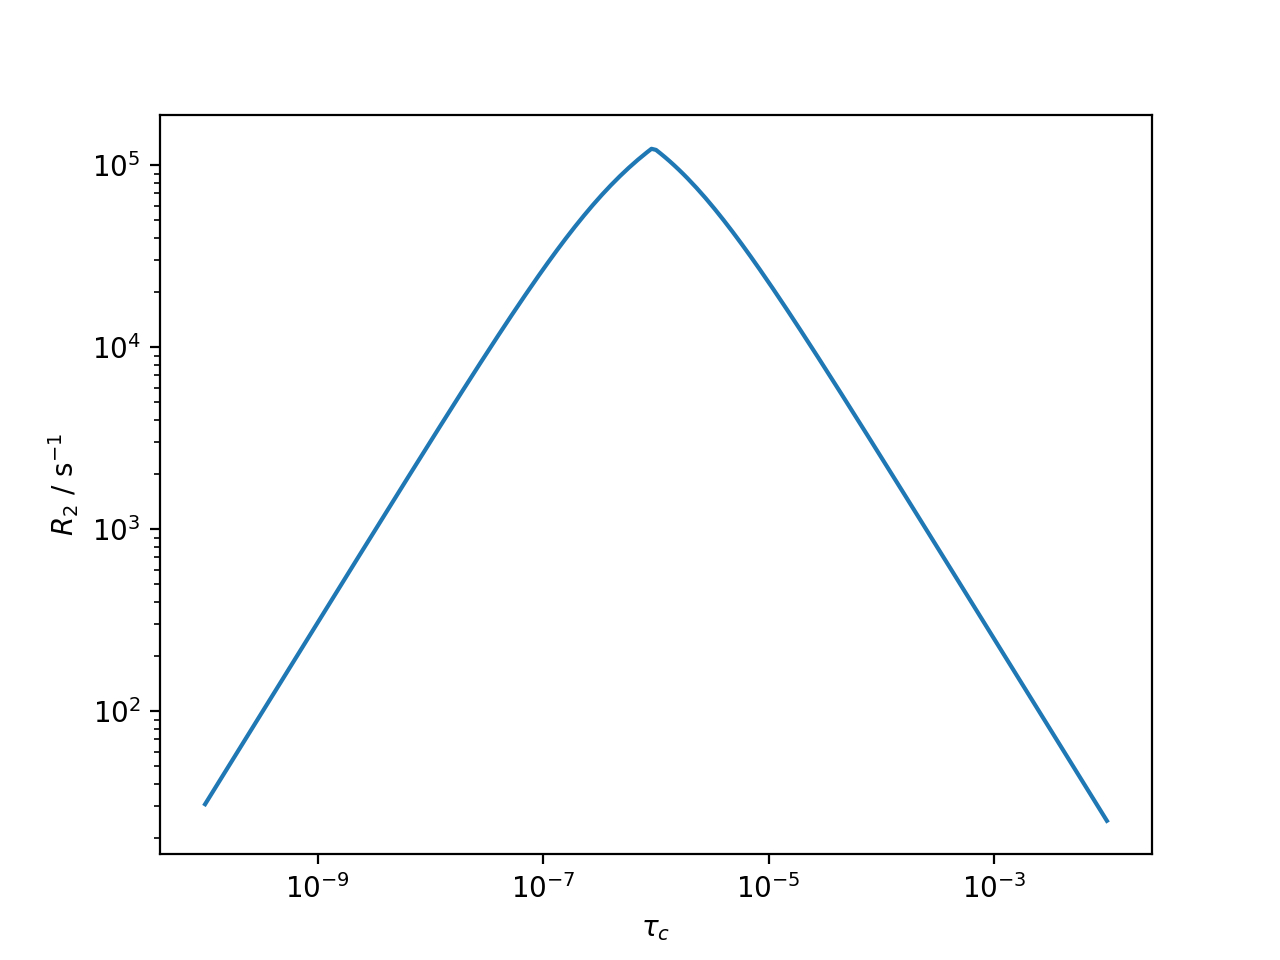

Text(0, 0.5, '$R_2$ / s$^{-1}$')

In [11]:
ax=plt.subplots(1,1)[1]
ax.loglog(tc0,rate)
ax.set_xlabel(r'$\tau_c$')
ax.set_ylabel(r'$R_2$ / s$^{-1}$')

Then, the relaxation rate constants become continuously faster up until the correlation time is comparable to the size of the hyperfine coupling. At this stage, the formulas are no longer valid and the relaxation rate constants decrease.

## Part 2: Relaxation due to electron $T_1$ and $T_2$ relaxation 

In this case, we only require one experimental system, but we will add $T_1$ and $T_2$ relaxation to the Liouvillian

In [12]:
ex0=RS.ExpSys(v0H=600,Nucs=['13C','e-'],LF=True)     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex0.set_inter(Type='hyperfine',i0=0,i1=1,Axx=5e5,Ayy=5e5,Azz=5e5)    #Hyperfine coupling

L=RS.Liouvillian(ex0)
L.add_relax(Type='T2',i=1,T2=1e-11)
U=L.U(Dt=0.1)

### Relaxation induced by electron $T_2$ relaxation

In the first test, we investigate whether an electron $T_2$ alone can indeed introduce relaxation to the nucleus.

<IPython.core.display.Javascript object>


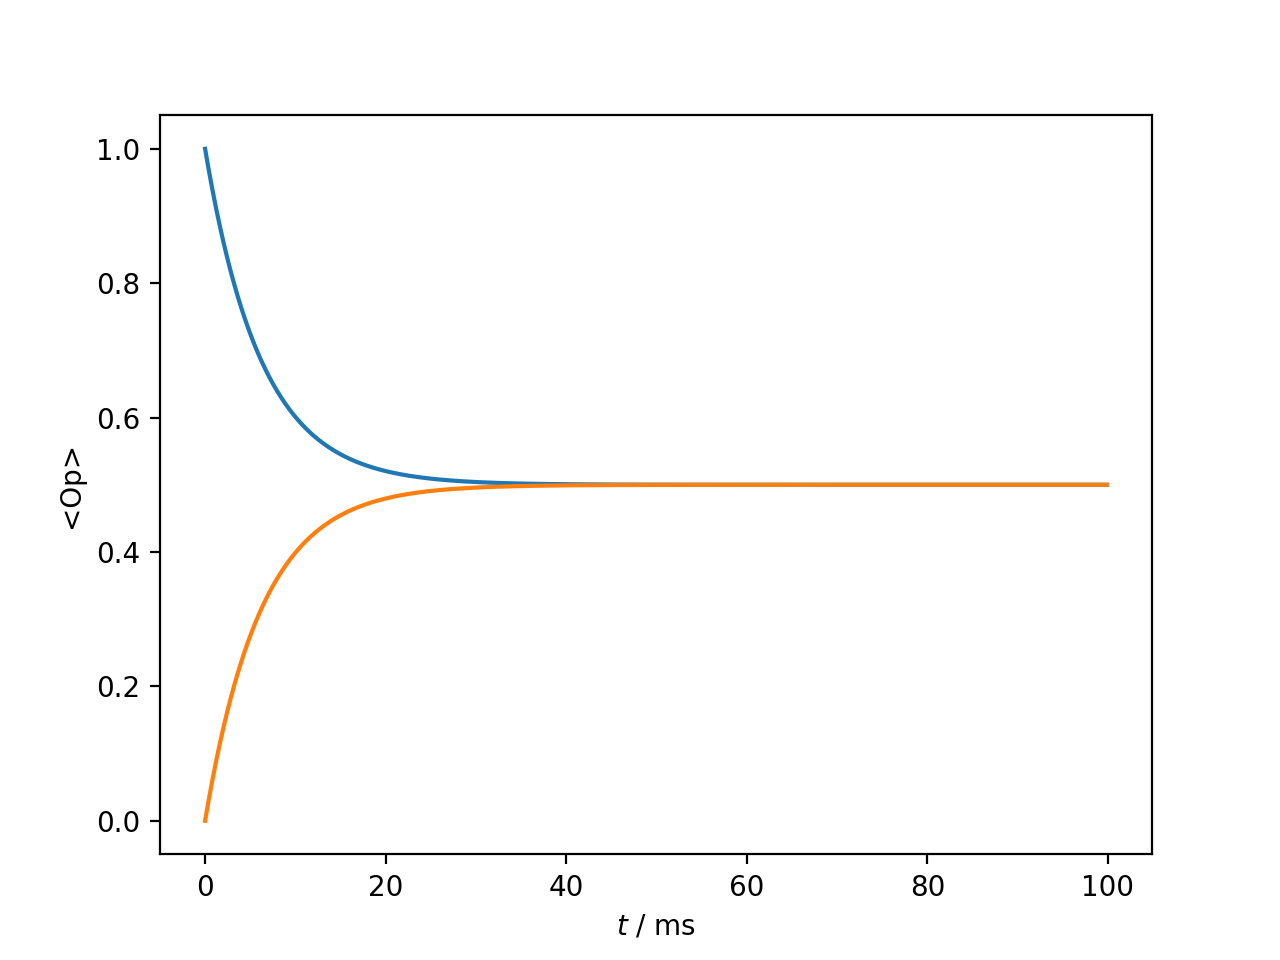

In [13]:
rho=RS.Rho(rho0='13Cz',detect=['13Cz','ez'])
rho.DetProp(U,n=1000)
_=rho.plot()

Indeed, the electron $T_2$ alone can induce Overhauser effect between the electron and nucleus. This is a result of the commutators:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I_z\right]\right]&=&\frac1{12}(I_z-S_z)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I_z\right]\right]&=&\frac1{12}(I_z-S_z)
\end{eqnarray}
Where the terms $I^-S^+$ and $I^+S^-$ are modulated by the electron $T_2$

<IPython.core.display.Javascript object>


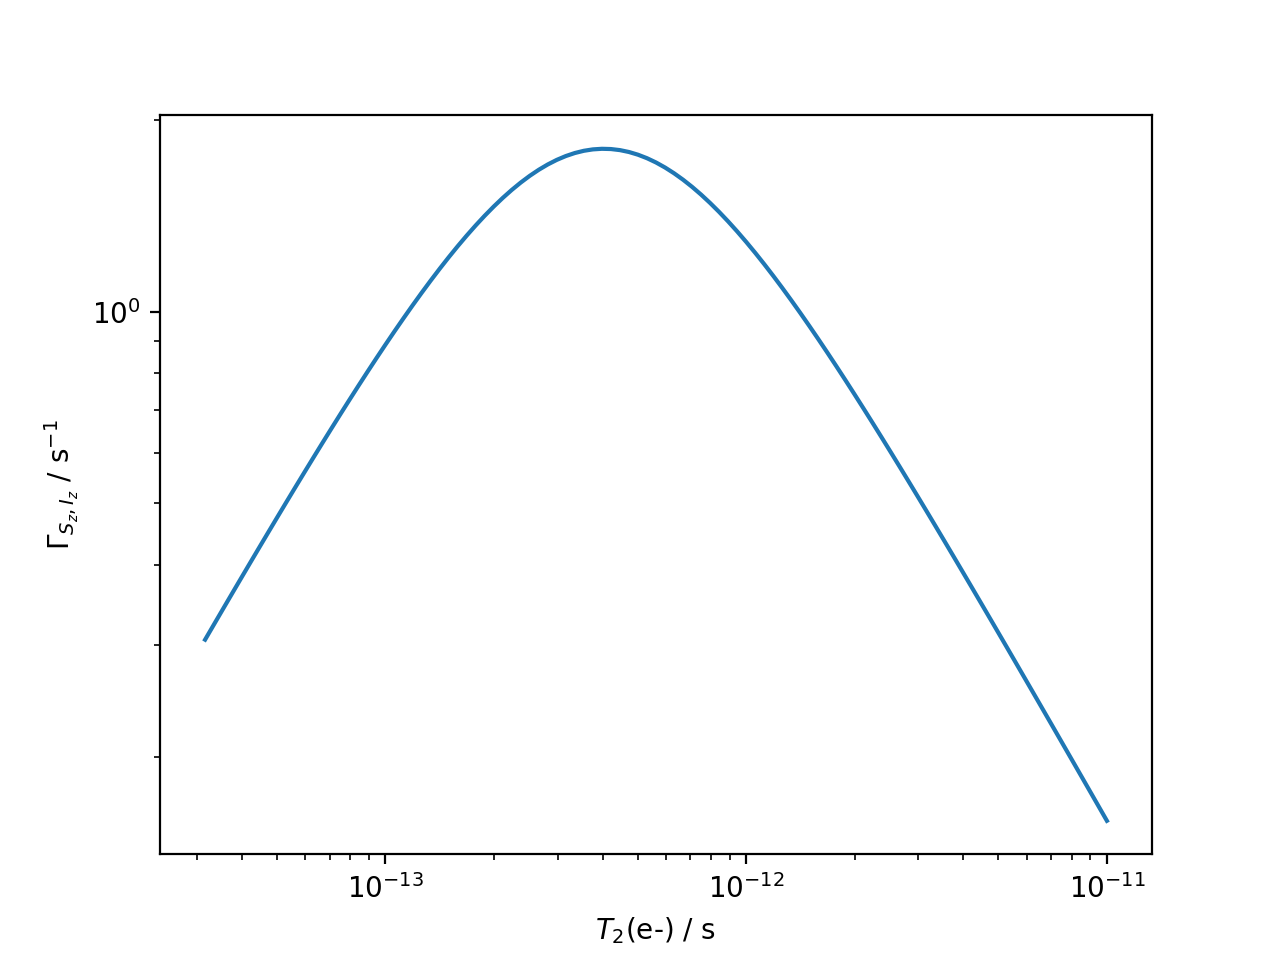

In [14]:
T20=np.logspace(-13.5,-11,101)
rate=list()
rho=RS.Rho(rho0='13Cz',detect='13Cz')
for T2 in T20:
    rho.clear()
    L.clear_relax()    #Note that added relaxation is cumulative, so we need to clear this every time
    L.add_relax(Type='T2',i=1,T2=T2)
    U=L.U(Dt=.1)
    (U*rho)()
    rate.append(2*(1-rho.I[0][0].real)/rho.t)
ax=plt.subplots(1,1)[1]
ax.loglog(T20,np.array(rate))
ax.set_xlabel(r'$T_2$(e-) / s')
_=ax.set_ylabel(r'$\Gamma_{S_z,I_z}}$ / s$^{-1}$')

The $T_2$ relaxation should only modulate the $I^+S^-$ and $I^-S^+$ terms. Due to the commutors:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{2\sqrt3}I^-S^+,I^+\right]\right]&=&\frac1{12}(I^+-S^+)\\
\left[T_{00},\left[-\frac1{2\sqrt3}I^+S^-,I^+\right]\right]&=&0
\end{eqnarray}
we expect that there should be $T_2$ relaxation on the nucleus

<IPython.core.display.Javascript object>


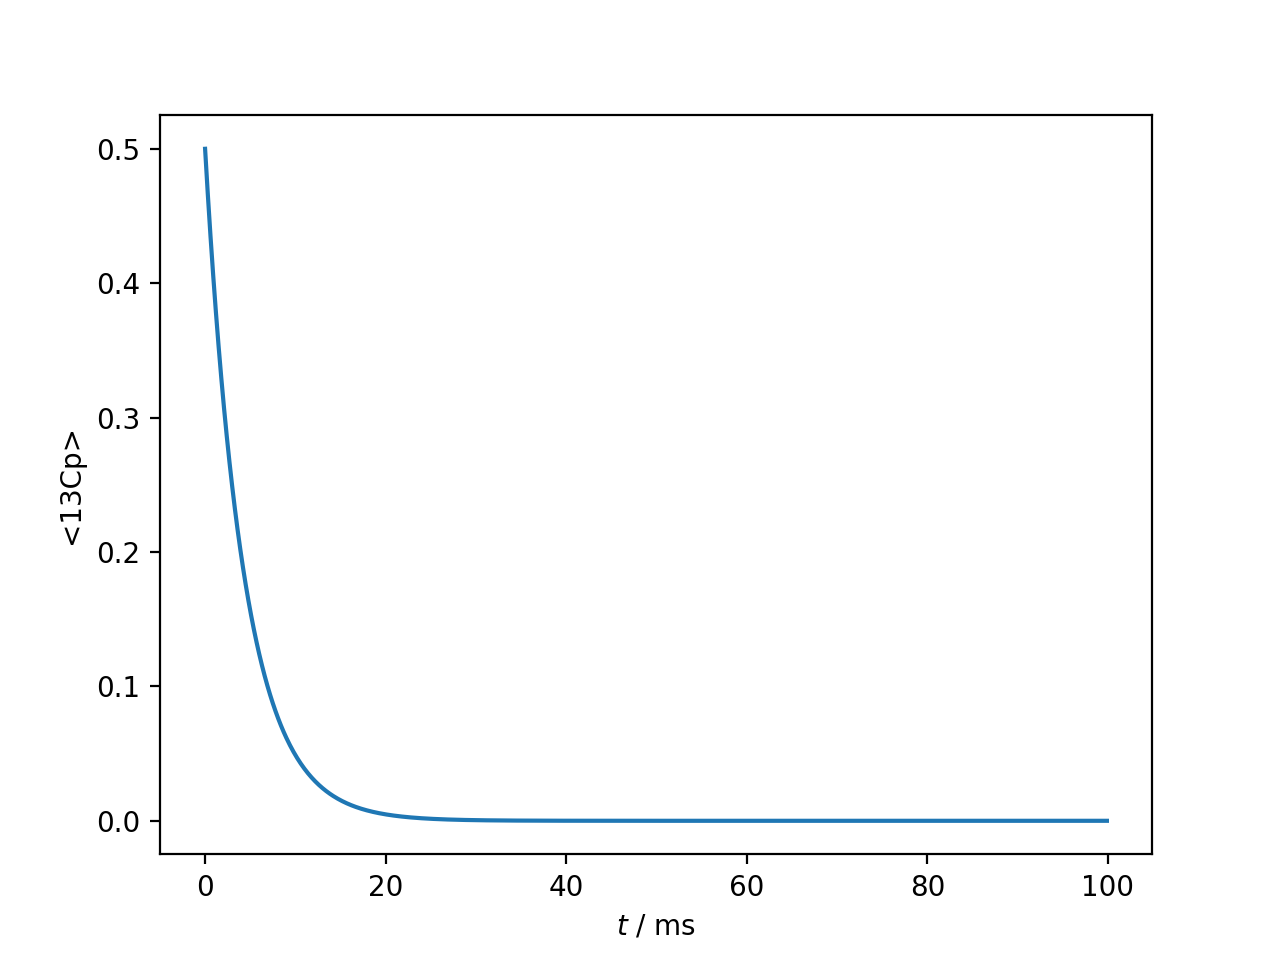

In [15]:
L.clear_relax()
L.add_relax(Type='T2',i=1,T2=1e-13)
U=L.U(Dt=0.1)
rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=1000)
_=rho.plot(mode='abs')

Next, we check the dependence on correlation time, where we again expect the maximum to occur at $1/\omega_{0,e}$, or ~400 fs

<IPython.core.display.Javascript object>


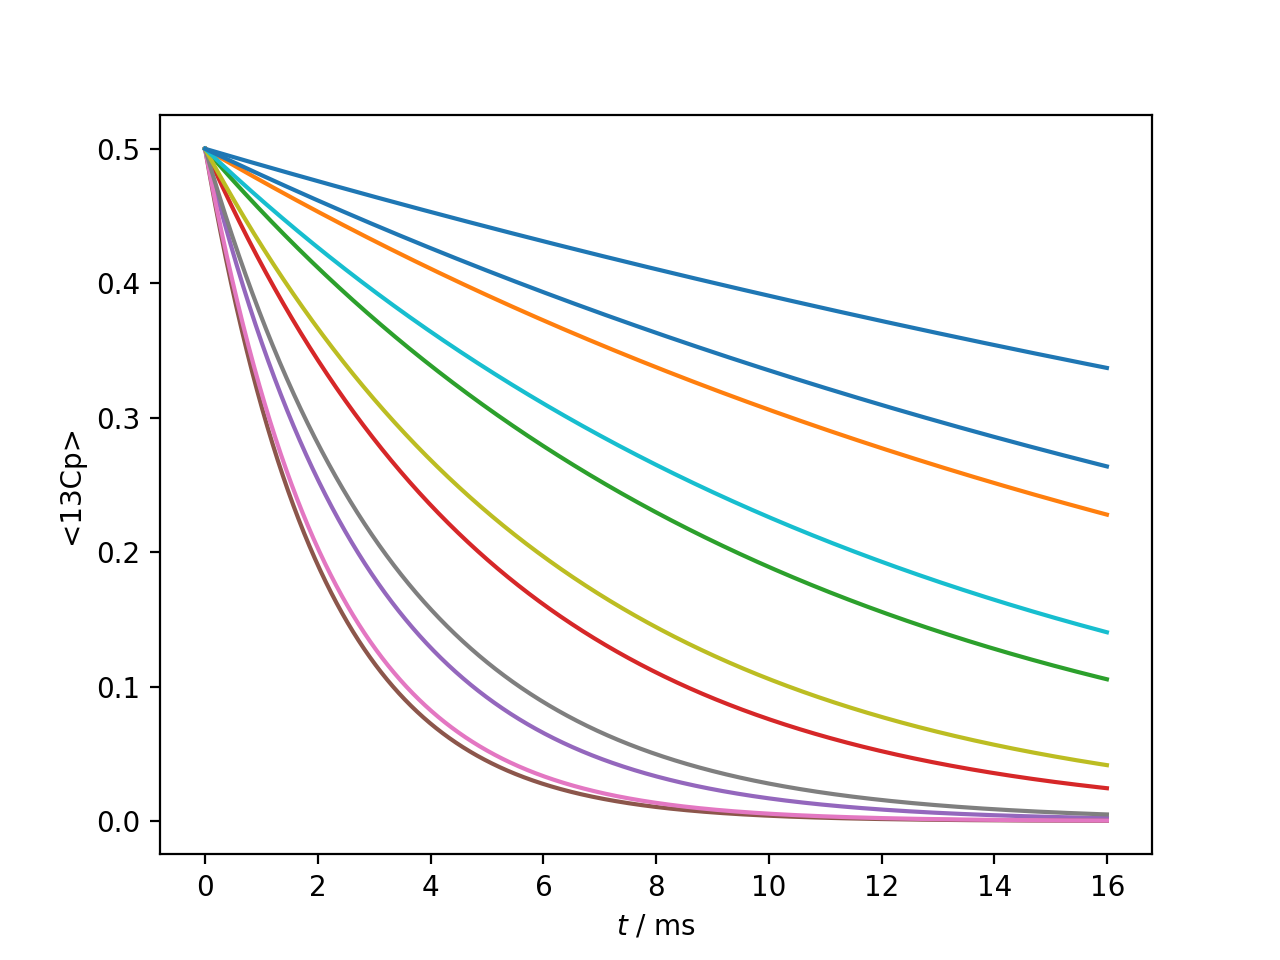

In [16]:
T20=np.logspace(-14,-11,201)
rate=list()
rho=RS.Rho(rho0='13Cx',detect='13Cp')
ax=plt.subplots(1,1)[1]
for k,T2 in enumerate(T20):
    rho.clear()
    L.clear_relax()
    L.add_relax(Type='T2',i=1,T2=T2)
    U=L.U(Dt=2000/5e5)
#     (U*rho)()
    rho.DetProp(U,n=4000)
    if k%20==0:
        rho.plot(ax=ax,mode='abs')
    rate.append((0.5-np.abs(rho.I[0][1]))/U.Dt)

<IPython.core.display.Javascript object>


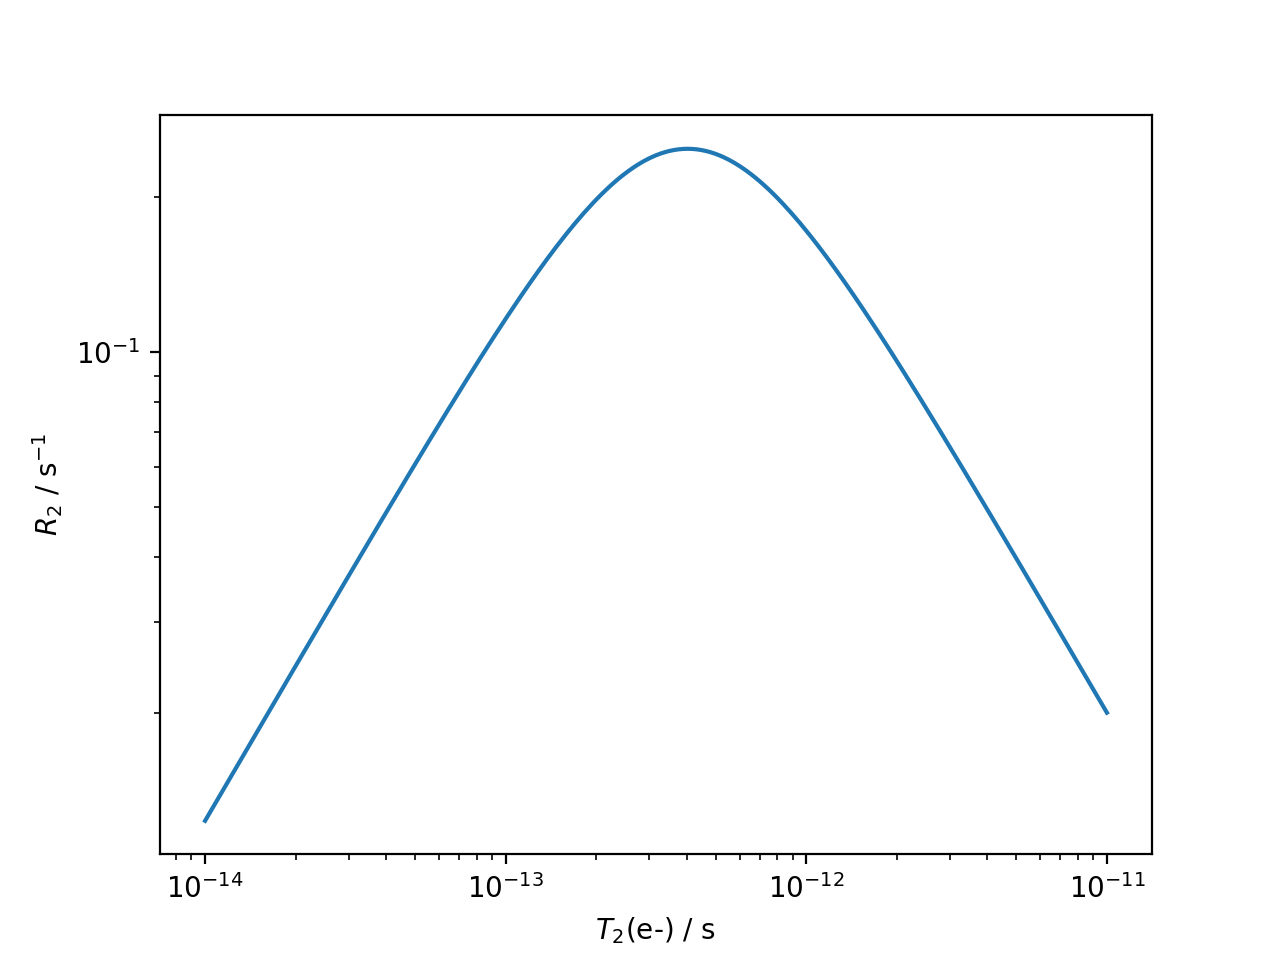

In [18]:
ax=plt.subplots(1,1)[1]
ax.loglog(T20,np.array(rate))
ax.set_xlabel(r'$T_2$(e-) / s')
_=ax.set_ylabel(r'$R_2$ / s$^{-1}$')

### Relaxation induced by electron $T_1$ relaxation
In this section, we'll add $T_1$ relaxation in addition to $T_2$ relaxation. In principal, we should not add $T_1$ relaxation without $T_2$, since this yields an unphysical system. However, we can keep $T_2$ fairly short to avoid it have a large influence. In the first example, we'll calculate with and without $T_1$ relaxation.

<IPython.core.display.Javascript object>


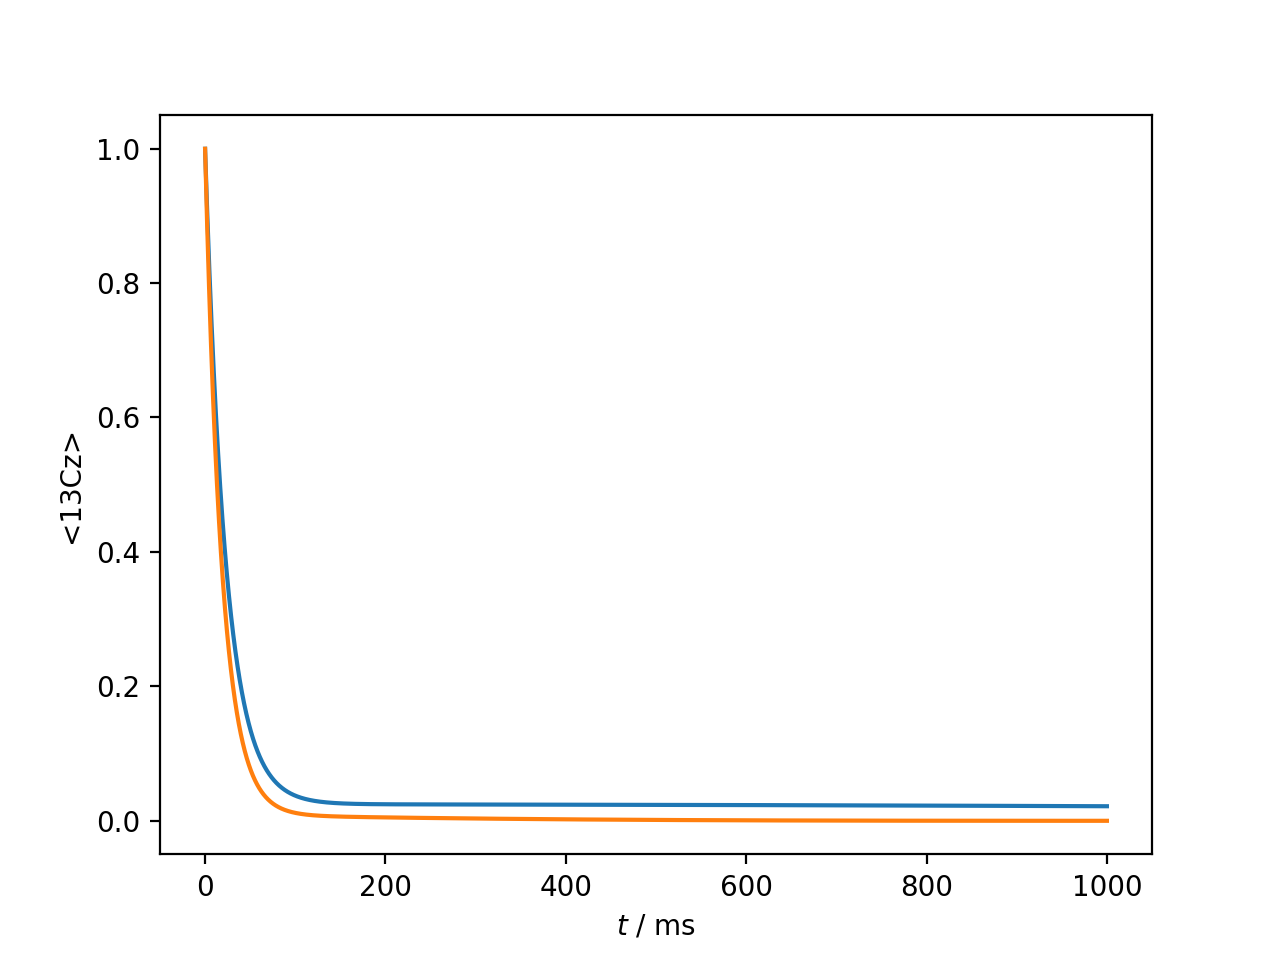

<AxesSubplot:xlabel='$t$ / ms', ylabel='<13Cz>'>

In [19]:
L.clear_relax()
L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-14)
U=L.U(Dt=0.1)
rho=RS.Rho(rho0='13Cz',detect='13Cz')
rho.DetProp(U,n=10000)
ax=plt.subplots(1,1)[1]
_=rho.plot(ax=ax)

L.clear_relax()
L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-9)
U=L.U(Dt=0.1)
rho.clear()
rho.DetProp(U,n=10000)
rho.plot(ax=ax)

Above, we see that the relaxation without and with $T_1$ relaxation of the electron are nearly identical (I'm not sure why they're slightly different). This is to be expected: $T_1$ only modulates the term $S_zI_z$, which commutes with the longitudinal terms:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I_z\right]\right]&=&0 \\
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,S_z\right]\right]&=&0
\end{eqnarray}
On the other hand, the commutator:
\begin{eqnarray}
\left[T_{00},\left[-\frac1{\sqrt3}I_zS_z,I^+\right]\right]&=&\frac1{12}(I^+-S^+) \\
\end{eqnarray}
suggests that the electron $T_1$ should induce significant transverse relaxation on the nucleus. As before, we will calculate without and with electron $T_1$ for comparison 

<IPython.core.display.Javascript object>


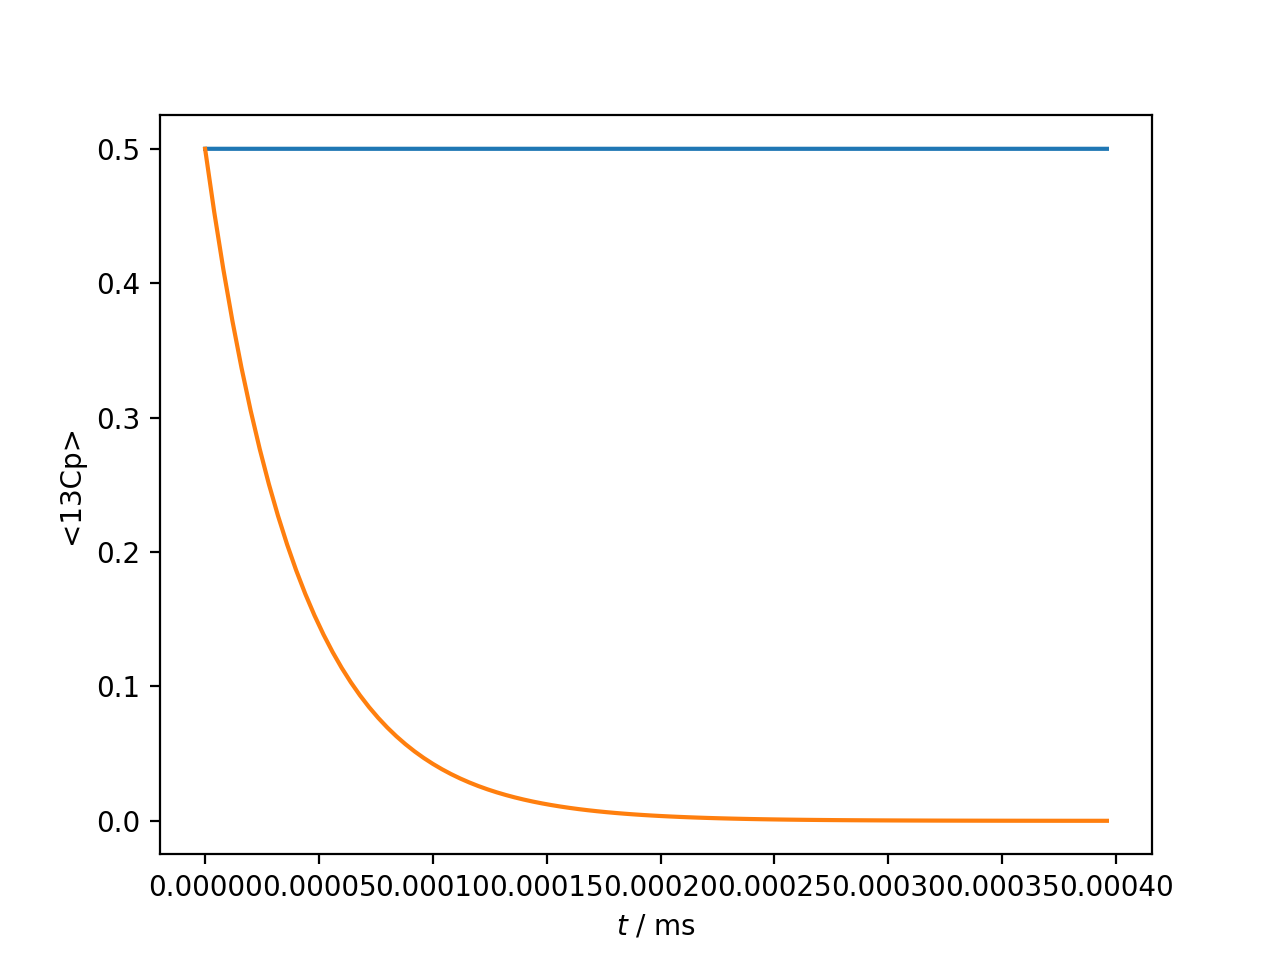

<AxesSubplot:xlabel='$t$ / ms', ylabel='<13Cp>'>

In [20]:
L.clear_relax()
L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-14)
U=L.U(Dt=2/5e5)

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
ax=plt.subplots(1,1)[1]
_=rho.plot(ax=ax,mode='abs')

L.clear_relax()
L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-8)
U=L.U(Dt=2/5e5)
rho.clear()
rho.DetProp(U,n=100)
rho.plot(ax=ax,mode='abs')

<IPython.core.display.Javascript object>


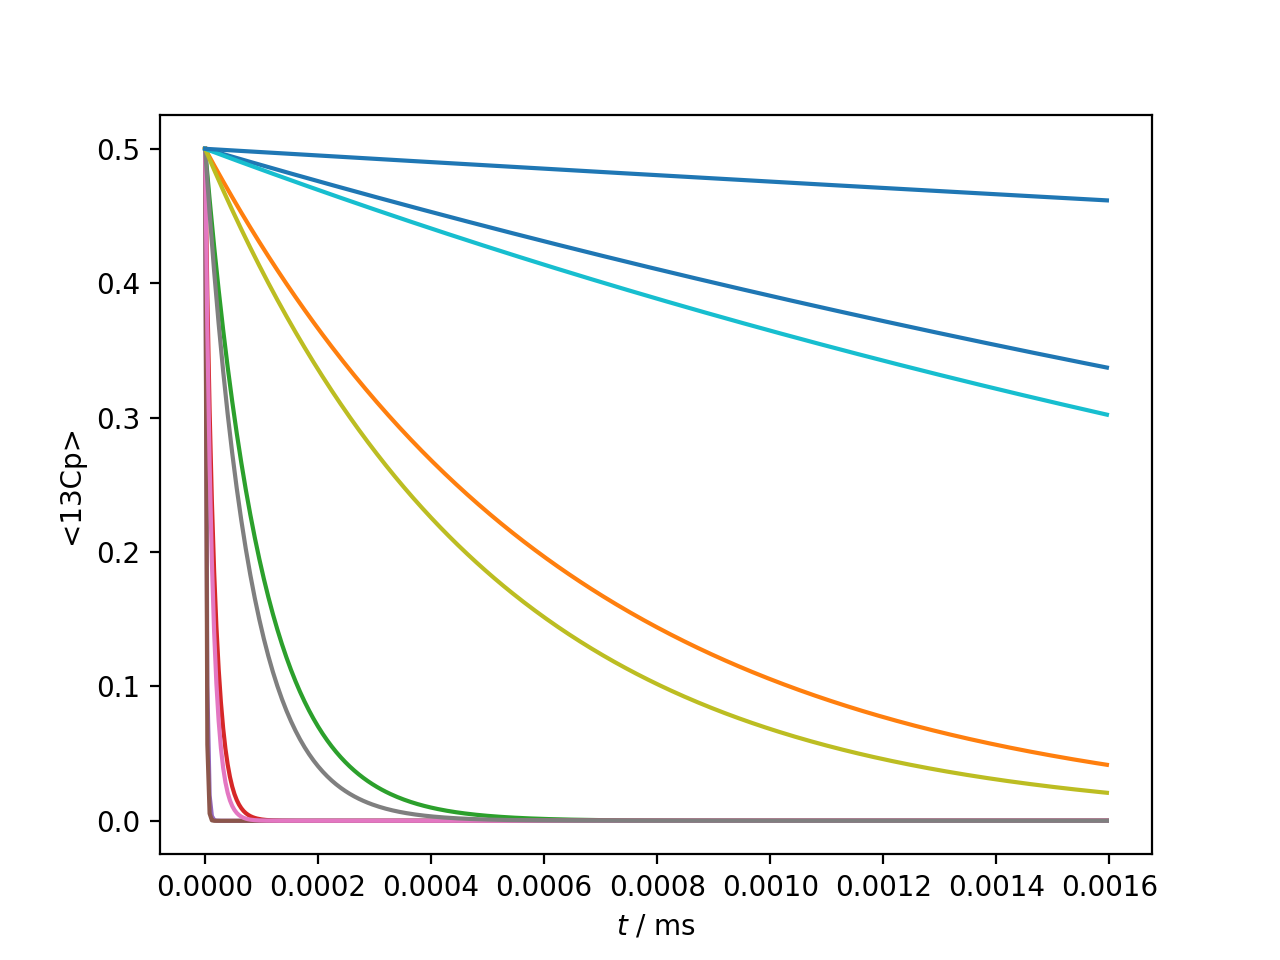

In [21]:
T10=np.logspace(-10,-2,201)
rate=list()
rho=RS.Rho(rho0='13Cx',detect='13Cp')
ax=plt.subplots(1,1)[1]
for k,T1 in enumerate(T10):
    rho.clear()
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=T1)
    L.add_relax(Type='T2',i=1,T2=T2)
    U=L.U(Dt=2/5e5)
#     (U*rho)()
    rho.DetProp(U,n=400)
    if k%20==0:
        rho.plot(ax=ax,mode='abs')
    rate.append((0.5-np.abs(rho.I[0][1]))/U.Dt)

<IPython.core.display.Javascript object>


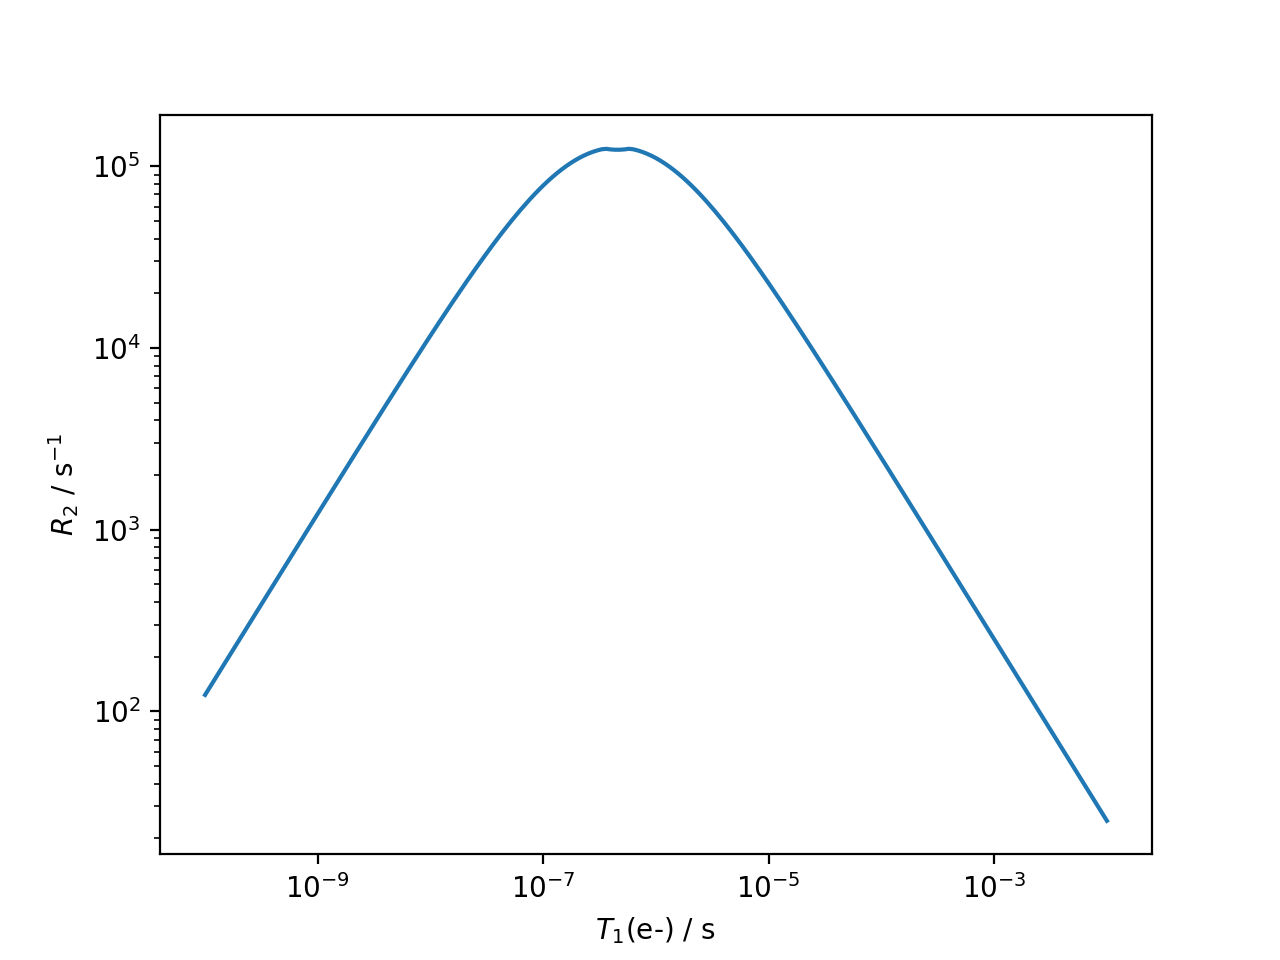

In [23]:
ax=plt.subplots(1,1)[1]
ax.loglog(T10,np.array(rate))
ax.set_xlabel(r'$T_1$(e-) / s')
_=ax.set_ylabel(r'$R_2$ / s$^{-1}$')

As with the exchange process, here we reach a maximum when the electron $T_1$ is approximately matched to the size of the isotropic hyperfine coupling

## Part 3: Combined Influence of Exchange and Electron Relaxation

In the following, we see how the combination of exchange processes and electron relaxation can impact the nuclear relaxation

In [10]:
ex0=RS.ExpSys(v0H=600,Nucs=['13C','e'],LF=True)     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex1=ex0.copy()
ex0.set_inter(Type='hyperfine',i0=0,i1=1,Axx=5e4,Ayy=5e4,Azz=5e4)    #Hyperfine coupling
ex1.set_inter(Type='hyperfine',i0=0,i1=1,Axx=1e4,Ayy=1e4,Azz=1e4)    #Hyperfine coupling

<IPython.core.display.Javascript object>


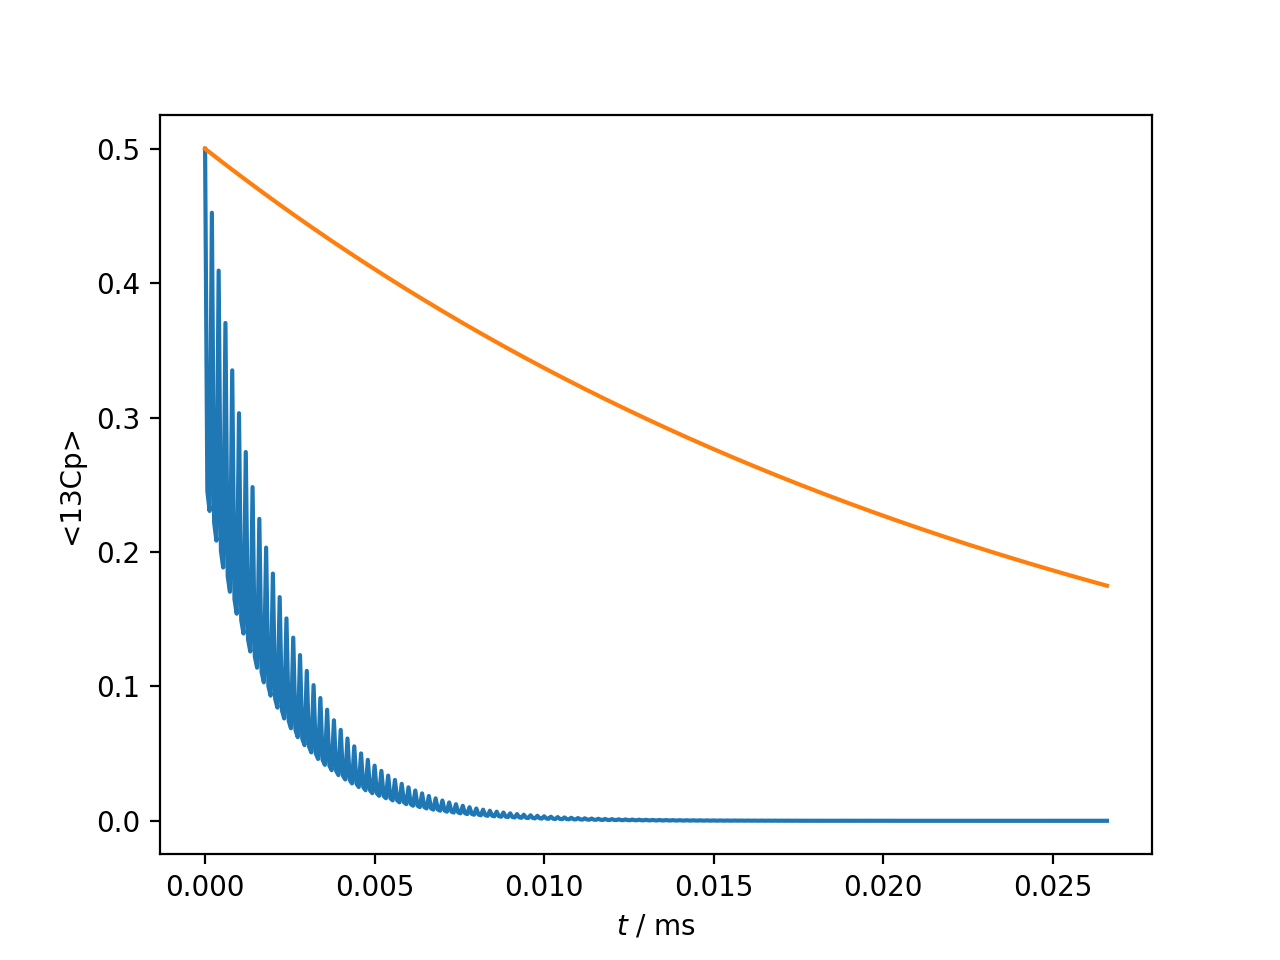

In [11]:
L=RS.Liouvillian((ex0,ex1))
L.kex=RS.Tools.twoSite_kex(tc=1e-3)

L.add_relax(Type='T2',i=1,T2=1e-14)

U=L.U(Dt=2/3e4)
ax=plt.subplots(1,1)[1]

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=400)
_=rho.plot(ax=ax,mode='abs')

L.kex=RS.Tools.twoSite_kex(tc=1e-8)
U=L.U(Dt=2/3e4)

rho.clear()
rho.DetProp(U,n=400)
_=rho.plot(ax=ax,mode='abs')

In the above example, the exchange is the dominant term yielding transverse relaxation. When it approachs the inverse size of the hyperfine, its influence becomes most significant. Note, however, if we introduce $T_1$ relaxation of the electron, then its influence is almost entirely removed– the electron $T_1$ averages away the coupling such that exchange no longer matters.

<IPython.core.display.Javascript object>


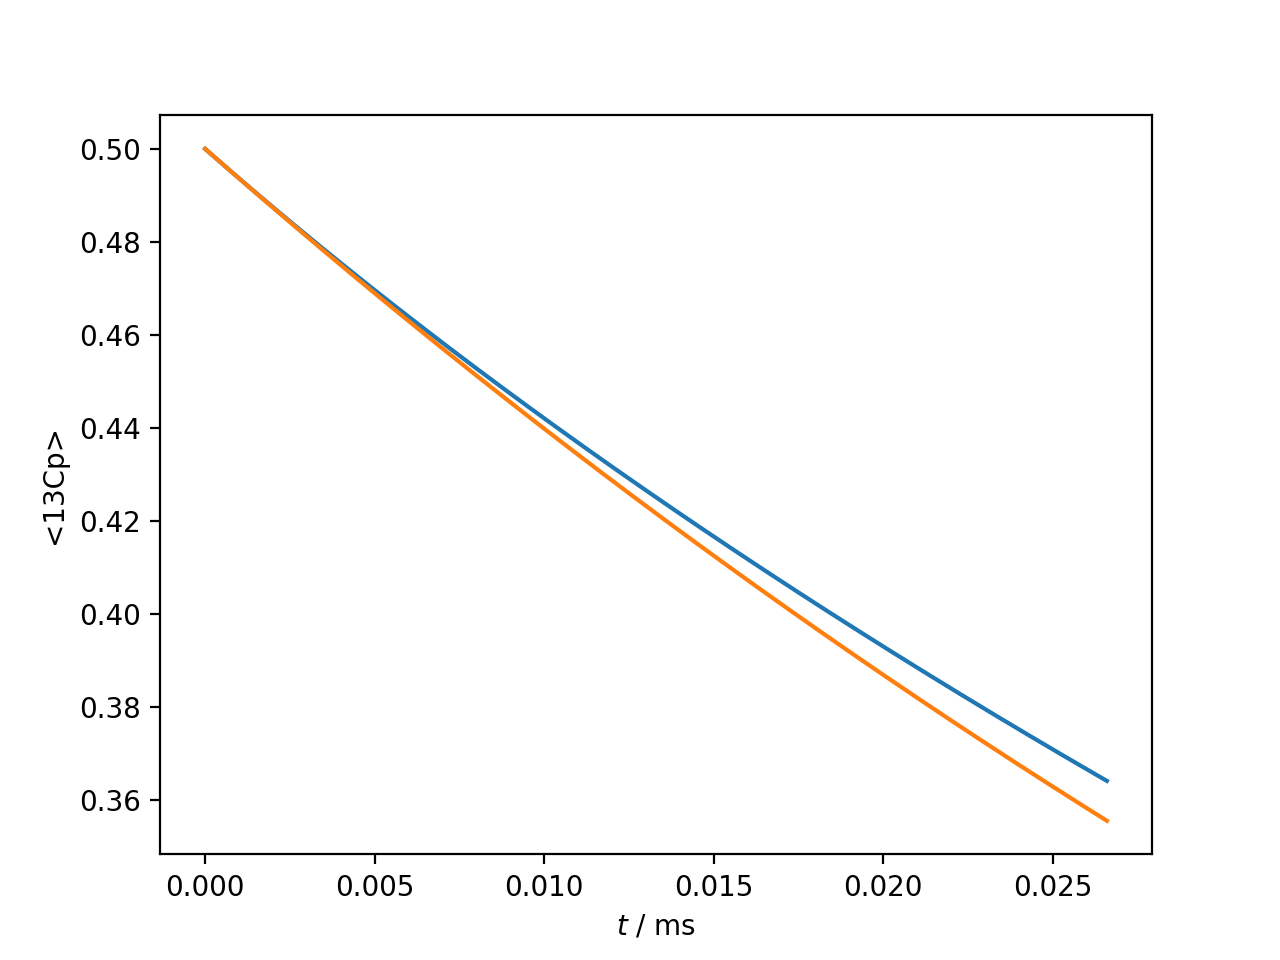

In [12]:
L=RS.Liouvillian((ex0,ex1))
L.kex=RS.Tools.twoSite_kex(tc=1e-2)

L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-9)

U=L.U(Dt=2/3e4)
ax=plt.subplots(1,1)[1]

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=400)
_=rho.plot(ax=ax,mode='abs')

L.kex=RS.Tools.twoSite_kex(tc=1e-6)
U=L.U(Dt=2/3e4)

rho.clear()
rho.DetProp(U,n=400)
_=rho.plot(ax=ax,mode='abs')

However, this is not an entirely realistic picture. If we consider the net polarization of the electron, then the $T_1$ averaging still yields a reduced hyperfine coupling and exchange still has some influence.

<IPython.core.display.Javascript object>


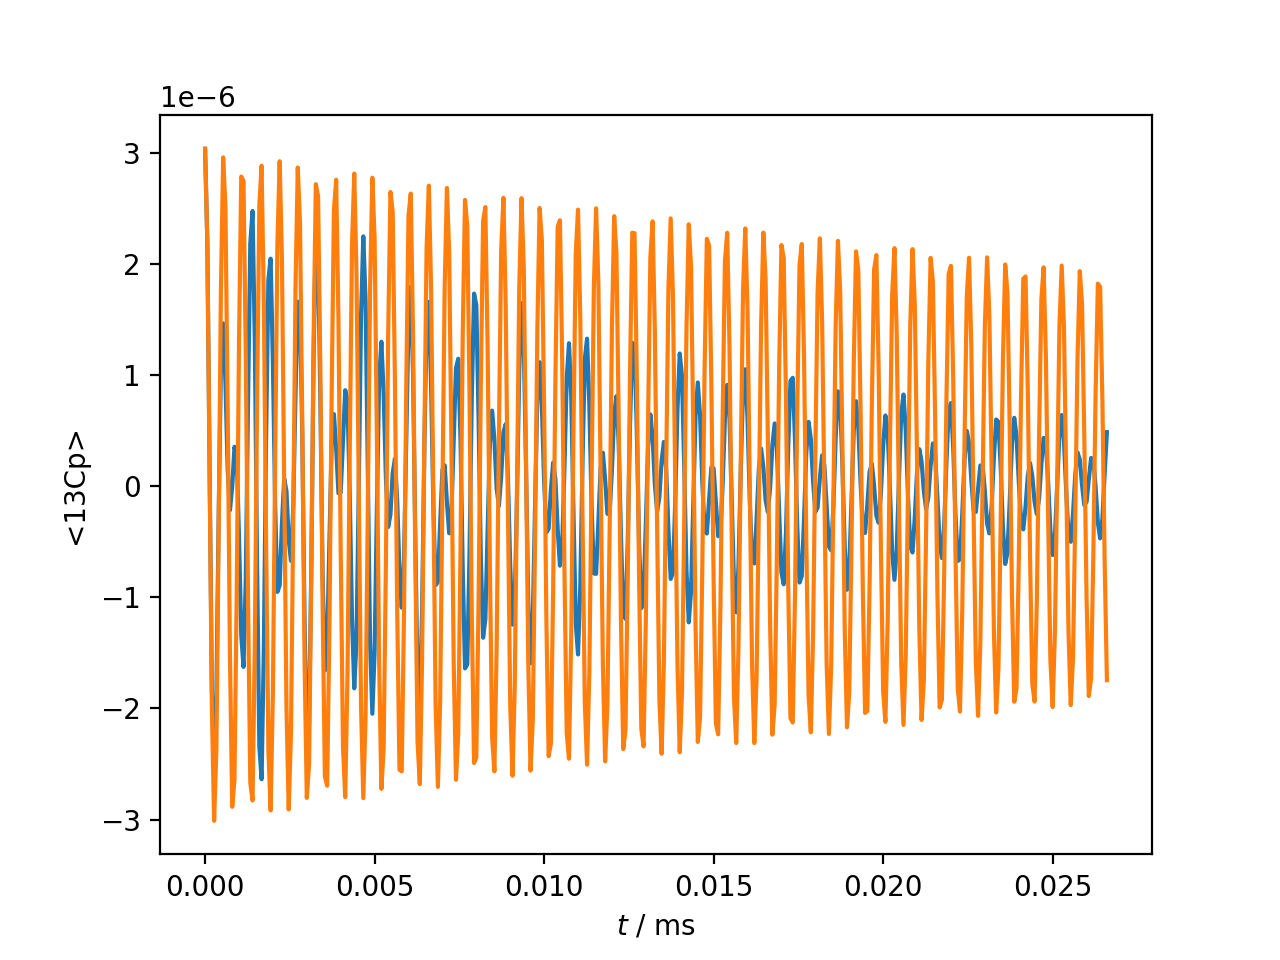

In [14]:
L=RS.Liouvillian((ex0,ex1))
L.kex=RS.Tools.twoSite_kex(tc=1e-2)

L.add_relax(Type='T2',i=1,T2=1e-14)
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='recovery')

U=L.U(Dt=2/3e4)
ax=plt.subplots(1,1)[1]

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=400)
_=rho.plot(ax=ax,mode='RE')

L.kex=RS.Tools.twoSite_kex(tc=1e-6)
U=L.U(Dt=2/3e4)

rho.clear()
rho.DetProp(U,n=400)
_=rho.plot(ax=ax,mode='RE')

In the first of the above two examples, there is no electron polarization, so the slower exchange process has very little impact (note that depending on which state the Hamiltonian is, there is slower or faster relaxation since the size of the Hyperfine is different– incomplete averaging for the slower exchange rate does lead to minor differences).

On the other hand, if some electron polarization is present, then there is a residual hyperfine coupling that may act on the nucleus and induce additional relaxation 